Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.3 MB/s eta 0:00:00
Mounted at /content/drive
  🧠 Fitting HMM on Training Data...


  ✅ HMM Converged: True

--- 🏛️ Running Classical Baselines ---
  > XGBoost...
  > Random Forest...
  > Buy & Hold...

⚙️ Tuning RL_Raw_PPO (PPO + Dense Rewards)...
  ✅ Best Sharpe: 0.01
  🚀 Continuing training RL_Raw_PPO for 60000 steps...

⚙️ Tuning RL_Wavelet_HMM_PPO (PPO + Dense Rewards)...
  ✅ Best Sharpe: 1.08
  🚀 Continuing training RL_Wavelet_HMM_PPO for 60000 steps...

--- 📊 Final Evaluation (Weights Preserved) ---

=== PERFORMANCE METRICS ===
              Total Return    Sharpe   Sortino  Max Drawdown     Alpha
Model                                                                 
RL_Raw_PPO        0.526847  0.979059  0.061439      0.131337  0.139613
RL_HMM_PPO        0.943662  1.258364  0.101739      0.145057  0.229619
XGBoost           0.846127  0.832227  0.070174      0.235721  0.000000
RandomForest      0.837088  0.764767  0.063597      0.369975  0.000000
BuyHold           0.434593  0.710681  0.063444      0.189022 -0.000174


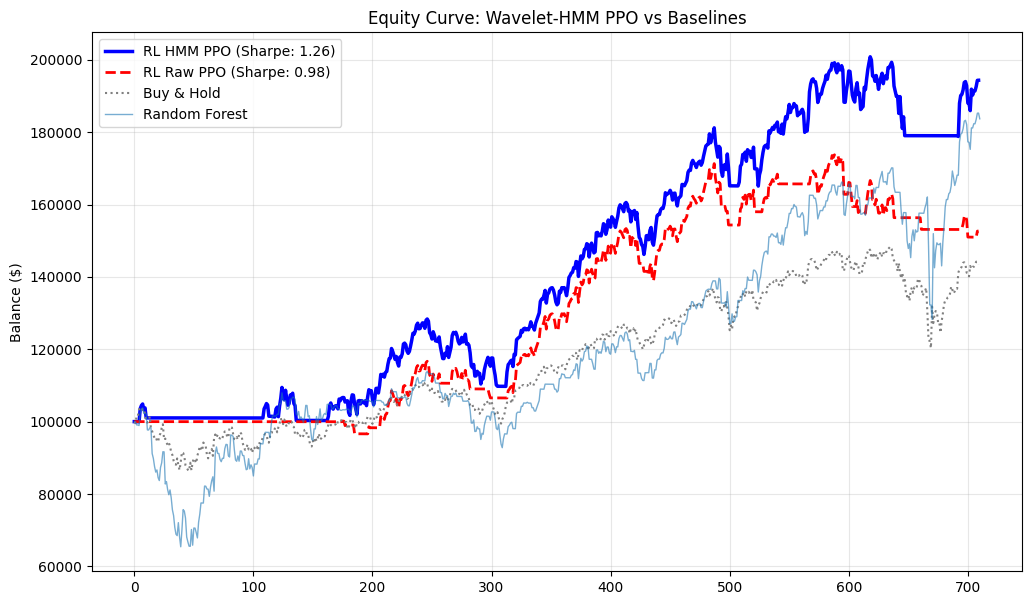

In [ ]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import gym
import torch as th
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from scipy import stats
import random
import warnings
import os
import math
from torch.nn import MultiheadAttention

# Suppress warnings
warnings.filterwarnings("ignore")

# Install dependencies if missing
try:
    import stable_baselines3
except ImportError:
    !pip install stable-baselines3 shimmy>=0.2.1

try:
    from hmmlearn.hmm import GaussianHMM
except ImportError:
    !pip install hmmlearn
    from hmmlearn.hmm import GaussianHMM

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# ==========================================
# 2. CONFIGURATION & SEEDS
# ==========================================
POINT_VALUE = 50
COMMISSION = 0.25
SPREAD = 0.25
INITIAL_BALANCE = 100000
TRAIN_TIMESTEPS = 60_000
TUNING_TIMESTEPS = 20_000 # Increased to ensure HMM features are learned

# PPO Hyperparameters (High Entropy to prevent collapse)
PPO_GRID = {
    'learning_rate': [3e-4],       # Robust default
    'n_steps': [2048],
    'batch_size': [64],
    'gamma': [0.99],
    'ent_coef': [0.03, 0.05]       # High entropy forces exploration
}

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    if hasattr(th.backends, 'cudnn'):
        th.backends.cudnn.deterministic = True
        th.backends.cudnn.benchmark = False

set_seeds(42)

# ==========================================
# 3. ADVANCED ARCHITECTURE (Attention + BiLSTM)
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = th.arange(max_len).unsqueeze(1)
        div_term = th.exp(th.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = th.zeros(max_len, d_model)
        pe[:, 0::2] = th.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = th.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = th.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class AdvancedFeatureExtractor(nn.Module):
    def __init__(self, observation_space, features_dim=64, n_heads=4, dropout=0.1):
        super(AdvancedFeatureExtractor, self).__init__()
        self.features_dim = features_dim
        input_dim = observation_space.shape[0]

        # Encoder
        hidden_dim = min(128, max(64, input_dim * 16))
        self.ff_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Attention
        attention_dim = hidden_dim // 2
        self.attention = MultiheadAttention(
            embed_dim=attention_dim,
            num_heads=min(n_heads, attention_dim // 16),
            dropout=dropout,
            batch_first=True
        )
        self.attention_norm = nn.LayerNorm(attention_dim)

        # BiLSTM
        self.bilstm = nn.LSTM(
            attention_dim,
            attention_dim // 2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0
        )
        self.lstm_norm = nn.LayerNorm(attention_dim)

        # Projection
        self.projection = nn.Sequential(
            nn.Linear(attention_dim, features_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(features_dim * 2, features_dim),
            nn.Tanh()
        )

        self.positional_encoding = PositionalEncoding(attention_dim, dropout=dropout)

    def forward(self, observations):
        original_shape = observations.shape
        if len(original_shape) == 1:
            observations = observations.unsqueeze(0)

        x = self.ff_encoder(observations)
        x = x.unsqueeze(1) # Add sequence dim
        x = self.positional_encoding(x)

        x_attn, _ = self.attention(x, x, x)
        x = self.attention_norm(x + x_attn)

        lstm_out, _ = self.bilstm(x)
        x = self.lstm_norm(lstm_out)

        x = x.squeeze(1)
        features = self.projection(x)

        if len(original_shape) == 1:
            features = features.squeeze(0)

        return features

# ==========================================
# 4. METRICS
# ==========================================
def calculate_complete_metrics(balance_history, price_data, benchmark_returns=None):
    if len(balance_history) < 2: return {}
    balance_history = np.array(balance_history)
    returns = np.diff(balance_history) / balance_history[:-1]
    returns = returns[np.isfinite(returns)]
    if len(returns) < 2: return {}

    total_return = (balance_history[-1] - balance_history[0]) / balance_history[0]
    rf = 0.02 / 252
    excess_returns = returns - rf
    std_dev = np.std(returns)
    sharpe = np.mean(excess_returns) / std_dev * np.sqrt(252) if std_dev > 0 else 0

    neg_returns = returns[returns < 0]
    downside_std = np.std(neg_returns) * np.sqrt(252) if len(neg_returns) > 1 else 0.001
    sortino = np.mean(excess_returns) * np.sqrt(252) / downside_std

    peak = np.maximum.accumulate(balance_history)
    dd = (peak - balance_history) / np.maximum(peak, 1)
    max_dd = np.max(dd)

    alpha, beta = 0.0, 0.0
    if benchmark_returns is not None and len(benchmark_returns) == len(returns):
        try:
            cov = np.cov(returns, benchmark_returns)[0][1]
            var = np.var(benchmark_returns)
            beta = cov / var if var > 0 else 0
            alpha = (np.mean(returns) - (rf + beta * (np.mean(benchmark_returns) - rf))) * 252
        except: pass

    return {
        "Total Return": float(total_return),
        "Sharpe": float(sharpe),
        "Sortino": float(sortino),
        "Max Drawdown": float(max_dd),
        "Alpha": float(alpha)
    }

# ==========================================
# 5. DATA LOADING & WAVELET-HMM
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/merged_data_with_vix_2.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Check path: {file_path}")

df = pd.read_csv(file_path, parse_dates=["date"])
df.set_index("date", inplace=True)
prices = df["PRICE"].values
indicators_raw = df[["DIX", "GEX", "VIX"]].values

def temporal_split(arr, ratios=(0.6, 0.2, 0.2)):
    n = len(arr)
    t1, t2 = int(n * ratios[0]), int(n * (ratios[0] + ratios[1]))
    return arr[:t1], arr[t1:t2], arr[t2:]

price_train, price_val, price_test = temporal_split(prices)
ind_train, ind_val, ind_test = temporal_split(indicators_raw)
benchmark_returns_test = np.diff(price_test) / price_test[:-1]

def wavelet_denoise(series, wavelet="coif4"):
    coeffs = pywt.wavedec(series, wavelet, level=2)
    threshold = np.std(coeffs[-1]) * 0.1
    coeffs[1:] = [pywt.threshold(c, threshold, "soft") for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)[:len(series)]

class WaveletHMM:
    def __init__(self, n_states=3, random_state=42):
        self.n_states = n_states
        self.random_state = random_state
        # Increased n_iter to prevent convergence warning
        self.model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, random_state=random_state)
        self.scaler = MinMaxScaler()

    def _compute_features(self, prices, vix, gex):
        ret = pd.Series(prices).pct_change().fillna(0).values
        ret_w = wavelet_denoise(ret)
        vol = pd.Series(ret).rolling(window=20).std().fillna(0).values
        vol_w = wavelet_denoise(vol)
        dvix = pd.Series(vix).diff().fillna(0).values
        dvix_w = wavelet_denoise(dvix)
        gex_w = wavelet_denoise(gex)
        X = np.column_stack([ret_w, vol_w, dvix_w, gex_w])
        return np.nan_to_num(X)

    def fit(self, prices, vix, gex):
        print("  🧠 Fitting HMM on Training Data...")
        X = self._compute_features(prices, vix, gex)
        self.model.fit(self.scaler.fit_transform(X))
        print(f"  ✅ HMM Converged: {self.model.monitor_.converged}")
        return self

    def get_probs(self, prices, vix, gex):
        X = self._compute_features(prices, vix, gex)
        return self.model.predict_proba(self.scaler.transform(X))

# --- BUILD HMM FEATURES ---
hmm = WaveletHMM(n_states=3).fit(price_train, ind_train[:, 2], ind_train[:, 1])

train_probs = hmm.get_probs(price_train, ind_train[:, 2], ind_train[:, 1])
val_probs   = hmm.get_probs(price_val,   ind_val[:, 2],   ind_val[:, 1])
test_probs  = hmm.get_probs(price_test,  ind_test[:, 2],  ind_test[:, 1])

## Stack: [DIX, GEX, VIX, P_State1, P_State2, P_State3]
#X_train_hmm = np.column_stack([ind_train, train_probs])
#X_val_hmm   = np.column_stack([ind_val,   val_probs])
#X_test_hmm  = np.column_stack([ind_test,  test_probs])











# --- NEW: Pre-calculate Denoised Indicators for RL Input ---

# 1. Denoise the raw indicators (DIX, GEX, VIX) column by column
# We use the same 'wavelet_denoise' function you defined earlier
X_train_denoised = np.column_stack([wavelet_denoise(ind_train[:, i], wavelet = "db4") for i in range(ind_train.shape[1])])
X_val_denoised   = np.column_stack([wavelet_denoise(ind_val[:, i], wavelet = "db4")   for i in range(ind_val.shape[1])])
X_test_denoised  = np.column_stack([wavelet_denoise(ind_test[:, i], wavelet = "db4")  for i in range(ind_test.shape[1])])

# 2. Stack the DENOISED signals with the HMM Probabilities
# New Stack: [Denoised_DIX, Denoised_GEX, Denoised_VIX, P_State1, P_State2, P_State3]
X_train_hmm = np.column_stack([X_train_denoised, train_probs])
X_val_hmm   = np.column_stack([X_val_denoised,   val_probs])
X_test_hmm  = np.column_stack([X_test_denoised,  test_probs])















# Scale
scaler_hmm = MinMaxScaler()
X_train_hmm = scaler_hmm.fit_transform(X_train_hmm)
X_val_hmm   = scaler_hmm.transform(X_val_hmm)
X_test_hmm  = scaler_hmm.transform(X_test_hmm)






# --- UPDATED CODE (Uses Denoised Data for Baseline) ---
# 1. Create the Denoised Data first
X_train_denoised_baseline = np.column_stack([wavelet_denoise(ind_train[:, i], wavelet = "db4") for i in range(ind_train.shape[1])])
X_val_denoised_baseline   = np.column_stack([wavelet_denoise(ind_val[:, i], wavelet = "db4")   for i in range(ind_val.shape[1])])
X_test_denoised_baseline  = np.column_stack([wavelet_denoise(ind_test[:, i], wavelet = "db4")  for i in range(ind_test.shape[1])])

# 2. Scale it and assign it to the variables used by 'model_raw'
scaler_raw = MinMaxScaler()
X_train_raw = scaler_raw.fit_transform(X_train_denoised_baseline) # <--- NOW passes Denoised signals
X_val_raw   = scaler_raw.transform(X_val_denoised_baseline)
X_test_raw  = scaler_raw.transform(X_test_denoised_baseline)












# ==========================================
# 6. CLASSICAL BASELINES
# ==========================================
def run_classical_baselines(X_train, y_train_labels, X_test, price_test):
    results = {}
    def simulate(preds, prices):
        bal = INITIAL_BALANCE
        pos = 0
        entry = 0
        hist = [bal]
        for i, sig in enumerate(preds):
            price = prices[i]
            if sig == 1 and pos == 0:
                pos = 1
                entry = price + SPREAD
                bal -= COMMISSION
            elif sig == 0 and pos == 1:
                pnl = (price - entry - SPREAD) * POINT_VALUE - COMMISSION
                bal += pnl
                pos = 0
            curr_bal = bal + ((price - entry - SPREAD) * POINT_VALUE if pos == 1 else 0)
            hist.append(curr_bal)
        return hist

    print("  > XGBoost...")
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
    xgb_model.fit(X_train, y_train_labels)
    results['XGBoost'] = simulate(xgb_model.predict(X_test), price_test)

    print("  > Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    rf.fit(X_train, y_train_labels)
    results['RandomForest'] = simulate(rf.predict(X_test), price_test)

    print("  > Buy & Hold...")
    results['BuyHold'] = [INITIAL_BALANCE * (p / price_test[0]) for p in price_test]
    return results

# Create Labels
y_train_lbl = ((pd.Series(price_train).pct_change().shift(-1) > 0).fillna(0).astype(int)).values
min_len = min(len(X_train_raw), len(y_train_lbl))
X_train_cls = X_train_raw[:min_len]
y_train_lbl = y_train_lbl[:min_len]

print("\n--- 🏛️ Running Classical Baselines ---")
baseline_curves = run_classical_baselines(X_train_cls, y_train_lbl, X_test_raw, price_test)

# ==========================================
# 7. RL TRAINING (PPO + DENSE REWARDS + WEIGHT PRESERVATION)
# ==========================================
class DenseRewardTradingEnv(gym.Env):
    def __init__(self, indicators, prices):
        super().__init__()
        self.ind = indicators.astype(np.float32)
        self.prices = prices.astype(np.float32)
        self.reset()
        self.observation_space = gym.spaces.Box(low=-10, high=10, shape=(self.ind.shape[1],))
        self.action_space = gym.spaces.Discrete(2)

    def reset(self):
        self.t = 0
        self.balance = INITIAL_BALANCE
        self.position = 0
        self.entry = 0
        self.history = [INITIAL_BALANCE]
        return self.ind[0]

    def step(self, action):
        current_price = self.prices[self.t]

        # Calculate Net Worth BEFORE
        pos_val = (current_price - self.entry - SPREAD) * POINT_VALUE if self.position else 0
        prev_nw = self.balance + pos_val

        # Action
        if action == 1 and self.position == 0:
            self.position = 1
            self.entry = current_price + SPREAD
            self.balance -= COMMISSION
        elif action == 0 and self.position == 1:
            pnl = (current_price - self.entry - SPREAD) * POINT_VALUE - COMMISSION
            self.balance += pnl
            self.position = 0

        # Calculate Net Worth AFTER
        pos_val_new = (current_price - self.entry - SPREAD) * POINT_VALUE if self.position else 0
        current_nw = self.balance + pos_val_new

        # Dense Reward: Scaled Change in Net Worth
        reward = (current_nw - prev_nw) / 1000.0

        self.history.append(current_nw)
        self.t += 1
        done = self.t >= len(self.prices) - 1
        obs = self.ind[self.t] if not done else np.zeros(self.ind.shape[1])
        return obs, reward, done, {}

def tune_and_train_ppo(X_tr, X_va, p_tr, p_va, name="Model"):
    print(f"\n⚙️ Tuning {name} (PPO + Dense Rewards)...")
    import itertools
    keys, values = zip(*PPO_GRID.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    if len(combinations) > 4: combinations = random.sample(combinations, 4)

    best_score = -np.inf
    best_model = None
    best_env = None

    for params in combinations:
        env_tr = DummyVecEnv([lambda: DenseRewardTradingEnv(X_tr, p_tr)])
        env_tr = VecNormalize(env_tr, norm_obs=True, norm_reward=True)

        policy_kwargs = dict(features_extractor_class=AdvancedFeatureExtractor,
                             features_extractor_kwargs=dict(features_dim=64, n_heads=2, dropout=0.1))

        model = PPO("MlpPolicy", env_tr, verbose=0, policy_kwargs=policy_kwargs, **params)
        model.learn(total_timesteps=TUNING_TIMESTEPS)

        # Validate (Using Training Env Normalization Stats)
        env_va = DenseRewardTradingEnv(X_va, p_va)
        obs = env_va.reset()
        done = False
        while not done:
            norm_obs = (obs - env_tr.obs_rms.mean) / np.sqrt(env_tr.obs_rms.var + 1e-8)
            action, _ = model.predict(norm_obs, deterministic=True)
            obs, _, done, _ = env_va.step(action)

        score = calculate_complete_metrics(env_va.history, p_va).get("Sharpe", -1)
        if score > best_score:
            best_score = score
            best_model = model
            best_env = env_tr

    print(f"  ✅ Best Sharpe: {best_score:.2f}")

    # Continue Training Winning Model (No Reset)
    print(f"  🚀 Continuing training {name} for {TRAIN_TIMESTEPS} steps...")
    if best_model:
        best_model.set_env(best_env)
        best_model.learn(total_timesteps=TRAIN_TIMESTEPS)
        return best_model, best_env
    else:
        # Fallback if tuning failed completely
        return model, env_tr

# Run RL
model_raw, env_raw = tune_and_train_ppo(X_train_raw, X_val_raw, price_train, price_val, "RL_Raw_PPO")
model_hmm, env_hmm = tune_and_train_ppo(X_train_hmm, X_val_hmm, price_train, price_val, "RL_Wavelet_HMM_PPO")

# ==========================================
# 8. EVALUATION & PLOT
# ==========================================
def evaluate(model, env_norm, X_t, p_t):
    test_env = DenseRewardTradingEnv(X_t, p_t)
    obs = test_env.reset()
    done = False
    while not done:
        norm_obs = (obs - env_norm.obs_rms.mean) / np.sqrt(env_norm.obs_rms.var + 1e-8)
        action, _ = model.predict(norm_obs, deterministic=True)
        obs, _, done, _ = test_env.step(action)
    return test_env.history

print("\n--- 📊 Final Evaluation (Weights Preserved) ---")
curves = {}
curves['RL_Raw_PPO'] = evaluate(model_raw, env_raw, X_test_raw, price_test)
curves['RL_HMM_PPO'] = evaluate(model_hmm, env_hmm, X_test_hmm, price_test)
curves.update(baseline_curves)

metrics_table = []
for name, curve in curves.items():
    m = calculate_complete_metrics(curve, price_test, benchmark_returns_test)
    m['Model'] = name
    metrics_table.append(m)

df_metrics = pd.DataFrame(metrics_table).set_index('Model')
print("\n=== PERFORMANCE METRICS ===")
print(df_metrics[['Total Return', 'Sharpe', 'Sortino', 'Max Drawdown', 'Alpha']])



plt.figure(figsize=(12, 7))
plt.plot(curves['RL_HMM_PPO'], label=f"RL HMM PPO (Sharpe: {df_metrics.loc['RL_HMM_PPO']['Sharpe']:.2f})", linewidth=2.5, color='blue')
plt.plot(curves['RL_Raw_PPO'], label=f"RL Raw PPO (Sharpe: {df_metrics.loc['RL_Raw_PPO']['Sharpe']:.2f})", linewidth=2, color='red', linestyle='--')
plt.plot(curves['BuyHold'], label="Buy & Hold", color='gray', linestyle=':')
plt.plot(curves['RandomForest'], label="Random Forest", linewidth=1, alpha=0.6)
plt.title("Equity Curve: Wavelet-HMM PPO vs Baselines")
plt.ylabel("Balance ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ==========================================
# 9. STRESS TESTING: SYNTHETIC 2008 CRASH
# ==========================================
def generate_crisis_scenario(original_prices, original_raw_indicators, hmm_model, scaler):
    """
    Morphs the test data into a '2008-style' crash and processes it
    through the exact Denoising+HMM pipeline.
    """
    print("\n🌪️ GENERATING SYNTHETIC '2008 CRISIS' SCENARIO...")
    n = len(original_prices)

    # --- 1. Synthesize RAW Crisis Data ---

    # A. Crash Curve (Sigmoid-like drop of 40%)
    t = np.linspace(0, 10, n)
    crash_curve = 1 - (0.4 / (1 + np.exp(-1 * (t - 5)))) # Drop occurs in middle
    crisis_prices = original_prices * crash_curve

    # B. Volatility & Gamma Spikes
    # VIX (Index 2), GEX (Index 1)
    crisis_raw_ind = original_raw_indicators.copy()

    # Volatility Spikes Inverse to Price (up to 3x)
    vol_spike = 1 + (1 - crash_curve) * 3.0
    crisis_raw_ind[:, 2] = crisis_raw_ind[:, 2] * vol_spike

    # GEX Collapses Negative (Gamma Squeeze)
    crisis_raw_ind[:, 1] = crisis_raw_ind[:, 1] - (vol_spike * 5000)

    # --- 2. Process Through Architecture Pipeline ---

    # A. Get Regime Context (HMM sees the new crisis patterns)
    print("  🧠 Re-calculating HMM States for Crisis Data...")
    # Note: hmm_db4 handles its own internal denoising
    crisis_probs = hmm_model.get_probs(crisis_prices, crisis_raw_ind[:, 2], crisis_raw_ind[:, 1])

    # B. Denoise the Signals (RL Agent expects db4 denoised inputs)
    print("  🌊 Applying Wavelet Denoising (db4) to Synthetic Data...")
    crisis_denoised_list = []
    for i in range(crisis_raw_ind.shape[1]):
        # Denoise DIX, GEX, VIX
        crisis_denoised_list.append(wavelet_denoise(crisis_raw_ind[:, i], wavelet="db4"))
    crisis_denoised = np.column_stack(crisis_denoised_list)

    # C. Stack & Scale [Denoised Signals || HMM Probs]
    X_crisis = np.column_stack([crisis_denoised, crisis_probs])
    X_crisis = scaler.transform(X_crisis) # Use the same scaler from training

    return X_crisis, crisis_prices

# --- EXECUTE STRESS TEST ---

# 1. Generate Data using the Best Components (db4)
# We use 'ind_test' (Raw) as the base to mutate
X_stress, p_stress = generate_crisis_scenario(price_test, ind_test, hmm_db4, scaler_hmm_d)

# 2. Select Best Agent
model_stress = model_hmm_db4
env_stats = env_hmm_db4 # For normalization stats

# 3. Run Simulation
print("  ⚔️ Running Execution Simulation...")
test_env = DenseRewardTradingEnv(X_stress, p_stress)
obs = test_env.reset()
done = False

while not done:
    # Normalize Observation using Training Statistics
    norm_obs = (obs - env_stats.obs_rms.mean) / np.sqrt(env_stats.obs_rms.var + 1e-8)

    # Predict
    action, _ = model_stress.predict(norm_obs, deterministic=True)
    obs, _, done, _ = test_env.step(action)

# --- VISUALIZATION ---
stress_metrics = calculate_complete_metrics(test_env.history, p_stress)
buy_hold_ret = (p_stress[-1] - p_stress[0]) / p_stress[0]

print(f"\n{'-'*60}")
print("💀 STRESS TEST RESULTS (SYNTHETIC 2008 SCENARIO)")
print(f"{'-'*60}")
print(f"📉 Market Return (Buy&Hold): {buy_hold_ret*100:.2f}% (CRASH)")
print(f"🛡️ Agent Return:            {stress_metrics['Total Return']*100:.2f}%")
print(f"📊 Agent Sharpe:             {stress_metrics['Sharpe']:.2f}")
print(f"📉 Max Drawdown:             {stress_metrics['Max Drawdown']*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(test_env.history, label='Regime-Augmented Agent', color='blue', linewidth=2.5)

# Re-scale market price to match starting equity for visual comparison
scaled_market = p_stress * (test_env.history[0] / p_stress[0])
plt.plot(scaled_market, label='Market (S&P 500 Crash)', color='red', linestyle='--', alpha=0.6)

plt.title(f"Resilience Test: Agent vs 40% Synthetic Crash")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Simulation Steps (Days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()